## Preface

This series of posts is based on a talk I held for the TS-CCES group at the Institute of Environmental Physics, Heidelberg in November 2016. I presented this Jupyter notebook directly using [RISE](https://github.com/damianavila/RISE), a Reveal.js plugin for Jupyter. This allowed me to demonstrate my code in action, and play around with it to clarify things or answer questions.

This talk was supposed to
1. give examples how to efficiently use Python in a scientific context; and
2. showcase some elegant code to convince scientists to learn Python.

To run this notebook yourself, just download the source of this post below. You will need to install a couple of packages for each example, e.g. using `pip` (or with `conda` if you're using Anaconda Python). All code should work with either Python 2.7 or Python 3.x.

Either way, let's start by importing some packages we're going to need later on. Most of them are staples in the scientific community (like Matplotlib, NumPy, and Pandas). I also like Seaborn for its powerful plotting capabilities and reasonable default styles.

In [1]:
%matplotlib inline
import numpy as np
import re
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set("talk")

## Reading data

Pretty much every scientist has to process data, and many scientists process *lots* of data. Unfortunately, real data tends to be messy - data files often include useless headers, or obscure information with ASCII formatting. The reason for this is that some scientists prioritize human-readability over machine-readability when deciding on a data format. Thus, simply parsing these formats efficiently can prove a challenge for inexperienced programmers. 

Let's create a (slightly exaggerated) messy data file with random values:

In [2]:
with open("testdata.csv","w") as f:
    f.write("A very useless header\n")
    f.write("Hi there and welcome to my file!\n")
    f.write(" ".join([str(k+1) for k in range(4)]) + "\n")
    testdata = np.random.randn(5,4)
    for row in testdata:
        f.write("; ".join(row.astype(str)) + "\n")
    f.write("Now comes the second part of the data!\n")
    f.write("---\n")
    f.write("n = 500, eta = 15.2, foo = bar\n")
    f.write("Here it comes, for real...\n")
    f.write(" ".join(["a"*(k+1) for k in range(4)]) + "\n")
    testdata = 2*np.random.randn(10,4)
    for row in testdata:
        f.write("; ".join((2*row).astype(str)) + "\n")

The resulting file looks like this:

In [3]:
with open("testdata.csv","r") as f:
    print(f.read())

A very useless header
Hi there and welcome to my file!
1 2 3 4
1.01279224467; -1.40721121402; 0.192842751725; 0.595397342458
-1.05822481949; -0.61410582863; 0.596548028352; 0.853507967801
0.246076579597; -1.35448464373; -0.779938173578; 0.345188055691
0.262451774711; 1.35126111693; 1.49356026657; 0.453345832019
1.12903508252; -1.27305328594; 0.832493332433; -0.030581958518
Now comes the second part of the data!
---
n = 500, eta = 15.2, foo = bar
Here it comes, for real...
a aa aaa aaaa
-6.24008319723; -6.48035897782; -0.823533303002; -1.49908931092
1.98427240052; 4.70480668601; 0.0751743413074; 2.12624545828
1.06353434804; 2.70013998953; 2.30704303872; 8.6070005543
-3.74041646994; 2.82899149542; -7.90406166748; -0.342154882168
2.60588751468; 4.02536593691; 8.22260968898; 4.19770846736
0.346589152382; -6.34719243209; -1.07003043414; 4.56629825728
-0.578032055078; 0.113274915084; -0.662370168426; -1.17887797792
1.12067342885; -0.609656609035; -1.1416924058; 9.85864125608
-5.24482604427; 

Since there are two separate data sets in one file mixed with headers, metadata, and comments, there is no way to parse this file with built-in readers (such as e.g. NumPy's `genfromtxt`). Thus, we need to write our own data parser. When extracting information from text, regular expressions have proven to be a powerful tool, with implementations in many languages. When developing regex patterns, I find it helpful to use a website such as [regexr.com](http://regexr.com/), which provides a cheat sheet listing each pattern, and allows for a more dynamical development.

To parse the data file above, I came up with the following patterns:

- One that matches a floating number:

In [4]:
re_float = r"[-+]?[0-9]*\.?[0-9]+(?:[eE][-+]?[0-9]+)?"
re.findall(re_float, "hi there! here's a float: +15e-06")

['+15e-06']

- One that matches the whitespace-separated data headers:

In [5]:
re_header = r"(\w+?)(?:$|\s+)"
re.findall(re_header, "0 1 2 3 4")

['0', '1', '2', '3', '4']

- One that matches the data itself, consisting of semicolon-separated floating numbers:

In [6]:
re_data = r"(" + re_float + ")+?\s*(?:\;|\s*$)?"
re.findall(re_data, "1e-15; 17.2; 32")

['1e-15', '17.2', '32']

- And one for the metadata, in the form of comma-separated key-value pairs:

In [7]:
re_metadata = r"\s*(\w+)\s*?=\s*(.+?)\s*(?:,|$)"
meta_dict = {k: v for k,v in re.findall(re_metadata, 
                    "n = 500, hey=there,this=that; or is it?")}
meta_dict["this"]

'that; or is it?'

Using these patterns, all we have to do to read the messy data file is to iterate through it line-by-line and check whether one of the patterns matches.

In [8]:
def read_data_block(f,h="<f8"):
    """
    Returns a contiguous block of data lines as structured numpy array
    """
    data = []
    for line in f:
        if not re.match(re_data,line):
            break
        data.append(tuple(map(float,re.findall(re_data,line))))
    return np.array(data, dtype=h)

def read_messy_file(filename):
    """
    Reads messy data file and returns lists of 
    found data and metadata
    """
    data = []
    meta = []
    header = []
    cur_meta = cur_header = cur_data = None
    with open(filename,"r") as f:
        for line in f:
            if re.match(re_metadata,line):
                cur_meta = {k: v for k,v in re.findall(re_metadata, line)}
                continue
            if re.match(re_header,line):
                cur_header = re.findall(re_header, line)
                continue
            if re.match(re_data,line):
                if cur_header:
                    cur_data = read_data_block(f,[(h,"<f8") for h in cur_header])
                else:
                    cur_data = read_data_block(f)
                data.append(cur_data)
                meta.append(cur_meta or {})
                header.append(cur_header or [])
                cur_meta = cur_header = cur_data = None
    return data, meta

In [9]:
data, meta = read_messy_file("testdata.csv")

All data is then contained in a structured NumPy array that can be indexed with the given column headers like a dictionary, and an actual dict containing all metadata:

In [10]:
print(data[1]["aa"])
print(meta[1])

[ 4.70480669  2.70013999  2.8289915   4.02536594 -6.34719243  0.11327492
 -0.60965661 -3.10285114 -4.75189104]
{'eta': '15.2', 'foo': 'bar', 'n': '500'}


Structured NumPy arrays can also be used to create Pandas DataFrame objects, which in turn play very well with Seaborn:

/home/dion/.virtualenvs/stats/local/lib/python2.7/site-packages/seaborn/categorical.py:2342: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


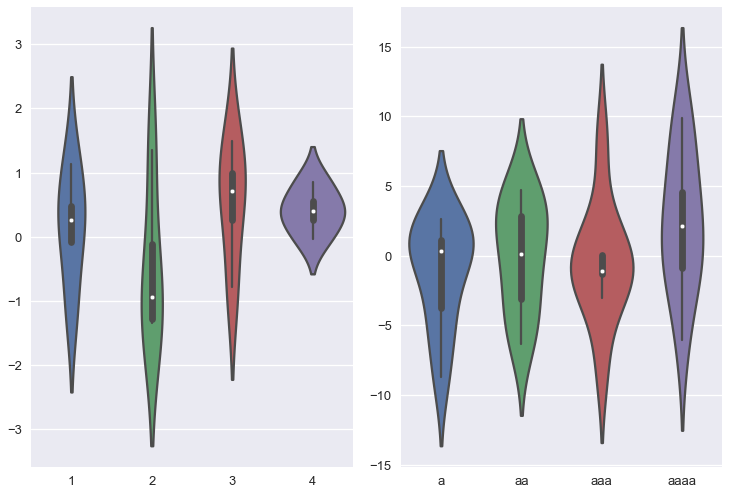

In [11]:
fig, axes = plt.subplots(1,2)
for d,ax in zip(data,axes):
    sns.violinplot(pd.DataFrame(d),ax=ax)
fig.tight_layout()

## Storing data

After putting so much effort into reading the data, it is important so make sure that it is saved in a more reasonable format the next time around. One great binary format for the storage of numeric arrays is HDF5. Bindings for HDF5 are available for many programming languages, such as C, C++, Fortran, Java, Ruby, and Python. This makes sure that your data will be readable, regardless of the tools you choose to process it. Since it is a binary format, you get the nice bonus effect of considerably smaller files, too.

For Python, the easiest way to work with HDF5 is `h5py` (available via `pip`). Saving the data from the messy data file to HDF5 becomes trivial:

In [12]:
with h5py.File("data.h5","w") as f:
    g1 = f.create_group("data1")
    g2 = f.create_group("data2")

    for g, d, m in zip((g1,g2), data, meta):
        dst = g.create_dataset("testdata", data=d)
        dst.attrs.update(m)
        dst.attrs["column_names"] = d.dtype.names

Reading data from a h5 file is just as easy:

['a' 'aa' 'aaa' 'aaaa']


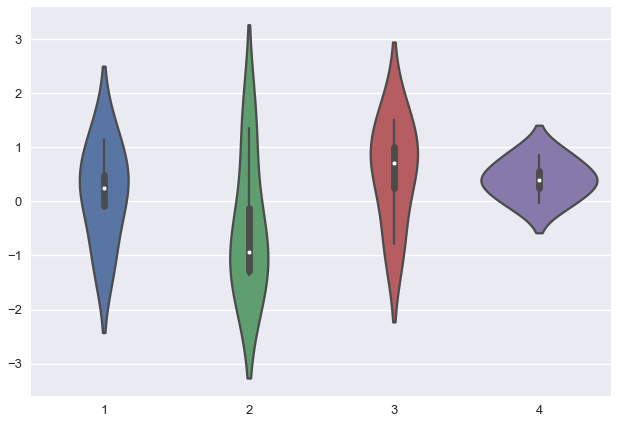

In [13]:
with h5py.File("data.h5","r") as f:
    d = np.array(f["data1/testdata"])
    sns.violinplot(pd.DataFrame(d))
    print(f["data2/testdata"].attrs["column_names"])

Note that [Pandas supports HDF5 I/O out of the box](http://pandas.pydata.org/pandas-docs/stable/io.html#io-hdf5), so if you decide to use Pandas instead of NumPy, storing data in the HDF5 format becomes even easier.